# Music Reviews: Pitchfork vs. TheNeedleDrop - WIP

<div style="text-align: left"> I read and watch a lot of reviews of music, because I listen to a lot of music and like to get the opinions and ideas of others on the stuff that I listen to. The largest outlet for music reviews (especially hip hop reviews) is Pitchfork, a site which I often feel misrepresents albums and gives too-high number ratings. Anthony Fantano, by contrast, is the "internet's busiest music nerd," the largest online independent music reviewer and cultural icon, going on Youtube by TheNeedleDrop. Fantano and I have many different opinions on music, but I feel like I at least get a more consistent voice out of him, and a more balanced number rating system. As a personal project I wanted to compare the two quantitatively, to see what I could tease out about each of their reviewing systems.

To get the Pitchfork reviews, I started to build a webscraper (rough draft is in this github folder) but realized that, because Pitchfork's scores are found only on the url of each review, I would have to open more than 24,000 urls, which on home wifi was looking like taking circa 50 hours. Luckily, someone on Kaggle has already done this, and so I use their database, sourced here: https://www.kaggle.com/nolanbconaway/pitchfork-data. I also borrow some code from this notebook based on the data: https://www.kaggle.com/nolanbconaway/is-the-first-album-the-best

The Fantano reviews were going to be even harder to scrape, as many are only shown in his youtube reviews. Luckily, a bigger fan than me has already completed this and posted his list to reddit here: https://www.reddit.com/r/fantanoforever/comments/6eu3dm/list_of_reviews_album_scores/. This google sheet has been downloaded as needledrop.csv. 

The Fantano list continues to be maintained, but the Pitchfork data is from 2017, so some recent albums are missing. Note also that while Pitchfork scores with decimals, Fantano scores only in whole numbers. </div>

## Importing Pitchfork Data

In [18]:
import sqlite3, datetime
import pandas as pd
import numpy as np

# Import Pitchfork reviews from Kaggle database
db = sqlite3.connect('pitchfork.sqlite')

# Put relevant variables into dataframes
pitchfork = pd.read_sql('SELECT reviewid, title, score, best_new_music FROM reviews', db)
artist = pd.read_sql('SELECT * FROM artists', db)
years = pd.read_sql('SELECT * FROM years', db)
genres = pd.read_sql('SELECT * FROM genres', db)
db.close()

# Merge into one dataframe 
# There may be a cleaner way to do this in one merge, couldn't find it
reviews_1 = pd.merge(pitchfork, years, on = 'reviewid')
reviews_2 = pd.merge(reviews_1, artist, on = 'reviewid')
reviews_3 = pd.merge(reviews_2, genres, on = 'reviewid')

# Drop ID and adjust var names
reviews_3 = reviews_3.drop(columns = 'reviewid')
reviews_3 = reviews_3.rename(index=str, columns={"score": "pitchfork", "best_new_music":"bnm"})

# Get size of dataframe
reviews_3.shape

(24424, 6)

24424 reviews!

## Import Fantano Data

In [19]:
# Read in Fantano reviews, from fan site google doc
fantano = pd.read_csv('needledrop.csv')

# Standardize case
fantano.artist = fantano.artist.str.lower()
fantano.title = fantano.title.str.lower()

fantano.shape

(1878, 3)

Only 1878 reviews - still a lot for a one-man team of less than 10 years. 

## Merge Dataframes

In [20]:
# Merge with Pitchfork reviews
reviews = pd.merge(reviews_3, fantano, on = ['artist' , 'title'], how='outer', indicator=True)

# Drop non-numeric reviews and clashes
reviews.fantano = pd.to_numeric(reviews.fantano, errors='coerce')
reviews = reviews[np.isnan(reviews.fantano) != True]
reviews = reviews[np.isnan(reviews.pitchfork) != True]

# Check shape again
reviews.shape

(995, 8)

<div style="text-align: left"> Down to 995 reviews. This is because some of Fantano's reviews are not reviewed by Pitchfork (and obviously vice versa), and also because some artist/album names are formatted slightly differently. Most of these naming sets are trivial - unicode differences, spaces, etc. - but given so many translated directly (n is still almost 1000!), I didn't feel a need to immediately try to rectify this. It's also reasonable to assume that there is no relation between the albums with small text differences, and (if that's true) we have a large random sample of the population, which should approximate any relationships well enough. Were this a more serious project, this would be something to fix. </div>

## Data Vis/Analysis

Let's look at the two distributions of scores:

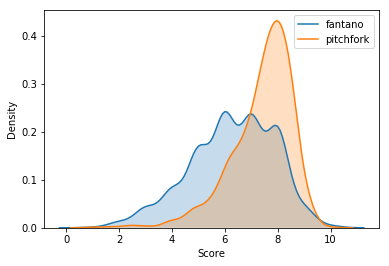

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.kdeplot(reviews.fantano, shade = True)
sns.kdeplot(reviews.pitchfork, shade = True)
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()

<div style="text-align: left"> We can see, as I suspected, that Pitchfork does seem to give higher reviews in general. Not only this, but their distribution is much steeper than Fantano's - they give reviews in a much smaller window. Let's check these stats quickly: </div>

In [22]:
def quicksumm(df):
    print "Mean = " + str(df.mean())
    print "Median = " + str(df.median())
    print "Upper Quartile = " + str(df.quantile(.75))
    print "Lower Quartile = " + str(df.quantile(.25))

print "Fantano:"
quicksumm(reviews.fantano)
print "\nPitchfork:"
quicksumm(reviews.pitchfork)

Fantano:
Mean = 6.2824120603
Median = 6.0
Upper Quartile = 8.0
Lower Quartile = 5.0

Pitchfork:
Mean = 7.4016080402
Median = 7.6
Upper Quartile = 8.2
Lower Quartile = 6.8


<div style="text-align: left"> This confirms what our eyes told us above. Pitchfork's mean score is 1.1 full points higher than Fantano's. The upper quartiles are similar, but Pitchfork rises 1.8 points higher on the lower quartile. This means that close to 75% of Pitchfork's scores are above a 7! </div>

<div style="text-align: left"> Another interesting place to look is the correlation between the two reviewing outlets. Are Fantano's reviews simply lower, but still in line with Pitchfork? Or is he also giving high reviews to low Pitchfork reviews, and vice-versa? Does what Pitchfork rate their albums have anything to do with what Fantano rates his albums? A simple way to look at this is the regression of Pitchfork scores on Fantano scores: </div>

In [23]:
import statsmodels.formula.api as smf

model = smf.ols('fantano ~ pitchfork', reviews)

# Use heteroskedasticity robust standard errors. This is equivalent to reg y x, robust in Stata
results = model.fit(cov_type='HC1') 

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                fantano   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     67.28
Date:                Wed, 25 Jul 2018   Prob (F-statistic):           7.26e-16
Time:                        00:11:16   Log-Likelihood:                -1817.3
No. Observations:                 995   AIC:                             3639.
Df Residuals:                     993   BIC:                             3648.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4454      0.354      9.745      0.000       2.752       4.138
pitchfork      0.3833      0.047      8.202      0.000       0.292       0.475
==============================================================================
Omnibus:                       21.806   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.785
Skew:                          -0.362   Prob(JB):                     1.13e-05
Kurtosis:                       2.837   Cond. No.                         49.1
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""